# Ford GoBike Program Analysis
Author: Aaron Olson

w205 - Data Engineering

Project Motivations:
- What are the 5 most popular trips that you would call "commuter trips"?
- What are your recommendations for offers (justify based on your findings)?

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## What Defines a Commuter Trip?

In [78]:
! bq query --use_legacy_sql=FALSE 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(HOUR FROM start_date) < 10) AND (EXTRACT(HOUR FROM start_date) > 7) AND (EXTRACT(DAYOFWEEK FROM start_date) > 1) AND (EXTRACT(DAYOFWEEK FROM start_date) <= 6)'

Waiting on bqjob_r7fc1dc69731a296_00000161ae7ddaf5_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 219263 |
+--------+


In [79]:
! bq query --use_legacy_sql=FALSE 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(HOUR FROM start_date) < 19) AND (EXTRACT(HOUR FROM start_date) > 16) AND (EXTRACT(DAYOFWEEK FROM start_date) > 1) AND (EXTRACT(DAYOFWEEK FROM start_date) <= 6)'

Waiting on bqjob_r99f7b44722a13d4_00000161ae7de832_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 196520 |
+--------+


Define the time windows for commuter trips as starting between 7-10 am and then again from 4-7 pm M-F. Since commuter trips are round-trip, the smaller number will estimate the number of commuter trips. This is a best estimate, which likely over-estimates the number of commuter trips, since there is a possiblity that a portion of the evening riders are not commuters, however we will use the number 196,520 as the number of commuters. Going forward we will define commuter trips as those that take place M-F between 4-7 pm. 

In [80]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT EXTRACT(DAYOFWEEK FROM start_date), count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(HOUR FROM start_date) < 19) AND (EXTRACT(HOUR FROM start_date) > 16) GROUP BY EXTRACT(DAYOFWEEK FROM start_date)' > result.csv

Waiting on bqjob_r3509b53053b05491_00000161ae7df383_1 ... (0s) Current status: DONE   

In [81]:
trips_by_day = pd.read_csv('result.csv')
trips_by_day.columns = ['day', 'rider_count']
trips_by_day['weekday'] = ['Thursday', 'Sunday', 'Monday', 'Friday', 'Tuesday', 'Wednesday', 'Saturday']
trips_by_day = trips_by_day.sort_values(by='day')
trips_by_day

,day,rider_count,weekday
1,1,6614,Sunday
2,2,40722,Monday
4,3,42922,Tuesday
5,4,41378,Wednesday
0,5,39052,Thursday
3,6,32446,Friday
6,7,7737,Saturday


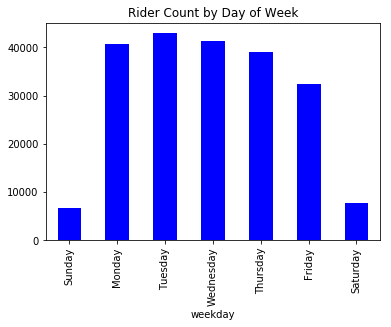

In [82]:
trips_by_day.plot.bar(x='weekday', y='rider_count', legend=False, title='Rider Count by Day of Week', color = 'b')

Looking at ridership by weekday, it is evident that Monday through Friday has the largest rider counts between 4-7 pm, which supports the notion that these riders are using the bikeshare system for commuting purposes. From this evidence, we will continue to define commuter trips as before (between 4-7 pm and occuring M-F). Using this information, it will be helpful to understand ridership breakdown throughout the year.

## Commuter Rider Count by Month

In [83]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT EXTRACT(MONTH FROM start_date), count(*) FROM (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(HOUR FROM start_date) < 19) AND  (EXTRACT(HOUR FROM start_date) > 16) AND (EXTRACT(DAYOFWEEK FROM start_date) > 1) AND (EXTRACT(DAYOFWEEK FROM start_date) <= 6)) GROUP BY EXTRACT(MONTH FROM start_date)' > result.csv

Waiting on bqjob_r42f92cc581f0a65c_00000161ae7e0216_1 ... (0s) Current status: DONE   

In [84]:
trips_by_month = pd.read_csv('result.csv')
trips_by_month.columns = ['month', 'count']
trips_by_month = trips_by_month.sort_values(by='month')
trips_by_month['month_name'] = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
trips_by_month

,month,count,month_name
5,1,14353,January
7,2,13946,February
6,3,16818,March
8,4,17618,April
4,5,17315,May
11,6,19455,June
9,7,18554,July
10,8,19303,August
0,9,16833,September
3,10,18394,October


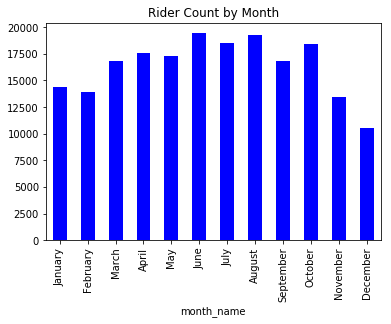

In [85]:
trips_by_month.plot.bar(x='month_name', y='count', legend=False, title='Rider Count by Month', color = 'b')

As would be expected, ridership drops off in the winter months when temperatures are cooler. It may be advisable to offer promotions during these months in order to keep bike utilization high. Having an understanding of ridership throughout the year, we will take a look at the most popular routes, in order to see where riders are using the bikes, ensuring that we had adequate supply at popular routes, and detecting any patterns for popular trips. 

## Location Breakdown for Commuter Trips

In [86]:
! bq query --use_legacy_sql=FALSE '  SELECT start_station_name, end_station_name, count(*) as trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(HOUR FROM start_date) < 19) AND (EXTRACT(HOUR FROM start_date) > 16)  AND (EXTRACT(DAYOFWEEK FROM start_date) > 1) AND (EXTRACT(DAYOFWEEK FROM start_date) <= 6) GROUP BY start_station_name, end_station_name ORDER BY trips DESC LIMIT 20'

Waiting on bqjob_r395b00a0a2b72daf_00000161ae7e102b_1 ... (0s) Current status: DONE   
+-----------------------------------------------+------------------------------------------+-------+
|              start_station_name               |             end_station_name             | trips |
+-----------------------------------------------+------------------------------------------+-------+
| Embarcadero at Sansome                        | Steuart at Market                        |  2703 |
| 2nd at South Park                             | Market at Sansome                        |  2574 |
| 2nd at Townsend                               | Harry Bridges Plaza (Ferry Building)     |  2450 |
| Market at 10th                                | San Francisco Caltrain 2 (330 Townsend)  |  2286 |
| Townsend at 7th                               | San Francisco Caltrain 2 (330 Townsend)  |  2068 |
| Steuart at Market                             | San Francisco Caltrain (Townsend at 4th) |  2065 |
| Em

Using our definition of commuter trips as those that take place between 4-7pm on M-F, we can see that the most common routes involve biking to a train station (13 of the 20 most popular trips). Presumably these are commuters who utilize the train to get close to work, and then take a bike to get to the specific office location and then return at night. 

From a commuting standpoint this makes sense. Additionally, knowing this information, we can ensure adequate bike allocation to train stations. Additionally, in order to increase ridership, it may be worthwhile to implement a promotion for those riders who pick up or drop off at a bike station. 

In [87]:
! bq query --use_legacy_sql=FALSE '  SELECT zip_code, count(*) as trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(HOUR FROM start_date) < 19) AND (EXTRACT(HOUR FROM start_date) > 16)  AND (EXTRACT(DAYOFWEEK FROM start_date) > 1) AND (EXTRACT(DAYOFWEEK FROM start_date) <= 6) GROUP BY zip_code ORDER BY trips DESC LIMIT 20'

Waiting on bqjob_r37427639367f0671_00000161ae7e1b8d_1 ... (0s) Current status: DONE   
+----------+-------+
| zip_code | trips |
+----------+-------+
| 94107    | 18692 |
| 94105    | 11209 |
| 94133    |  8964 |
| 94103    |  7010 |
| 94111    |  6580 |
| 94102    |  5608 |
| 94109    |  3566 |
| 94611    |  3561 |
| 95112    |  3139 |
| 94158    |  3104 |
| 94403    |  2976 |
| 94602    |  2893 |
| 94010    |  2859 |
| 94610    |  2816 |
| 94117    |  2529 |
| 94040    |  2501 |
| 94025    |  2387 |
| 94501    |  2374 |
| 95110    |  2147 |
| 94041    |  2135 |
+----------+-------+


Analyzing the zip code data, we can see that ridership primarily occurs in the 94107 - which correlates to Dogpatch and South Beach districts within the city. Ridership drops down to below 4000 trips in the database after 7 zip codes. 

This data can be used to ensure adequate bike resources are placed in areas which are more profitable (more trips).

## Computation of Break Even Point for current Price Plans

- Active days per month: At 0.8 days/month activity level an annual membership makes the most since (assuming day pass vs annual)
- Active trips per day: At 3.33 trips/day activity level, a day pass makes the most sense (assuming single vs day pass)
- Active weeks per year: At 5 weeks/year an annual membership makes sense over a day pass (assuming two trips/day for 5 days/week)

From this data, we can see that commuters benefit from purchasing annual memberships. 

## Recommendations based on analysis

- Using location data, ensure adequate bikes per station are available for users (see zip code and most popular trip queries)
- Offer commuter annual pass which enables two trips per day (one round trip) for Monday through Friday trips (all other trips available at single ride fee)
- Potentially offer discount for trips starting/ending at train station: As noted earlier, many popular trips go to or from train station. This helps Ford to encourage ridership for commuters and allows them to increase bikes per station at train stations (stable ridership patterns)
- Offer commuter day pass (two 30-min ride in 24 hrs) for \$5 (less than 2x one-way trips)
  